# Eksploracja i analiza danych

## Analiza aktywności użytkowników na forum

In [1]:
#| output: false
from pyspark.sql import (
    SparkSession,
    functions as f
    )
import matplotlib

spark = SparkSession.builder.appName("EDA").getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1674163994248_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
posts = spark.read.format('parquet').load("s3://preprocessed-data-beer-and-wine//posts")
posts.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[accepted_answer_id: int, answer_count: int, body: string, body_clean: string, closed_date: timestamp, comment_count: int, community_owned_date: timestamp, content_licence: string, creation_date: timestamp, favourite_count: int, id: int, last_activity_date: timestamp, last_edit_date: timestamp, last_editor_display_name: string, last_editor_user_id: int, owner_user_id: int, post_type_id: int, parent_id: int, score: int, tags: string, title: string, view_count: int]

In [61]:
posts.describe().show(vertical=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------------------------------
 summary                  | count                
 accepted_answer_id       | 690                  
 answer_count             | 1147                 
 body                     | 3843                 
 body_clean               | 3843                 
 comment_count            | 3843                 
 content_licence          | 3843                 
 favourite_count          | 24                   
 id                       | 3843                 
 last_editor_display_name | 23                   
 last_editor_user_id      | 1492                 
 owner_user_id            | 3805                 
 post_type_id             | 3843                 
 parent_id                | 2529                 
 score                    | 3843                 
 tags                     | 1147                 
 title                    | 1147                 
 view_count               | 1147                 
-RECORD 1----------------------------------------


In [4]:
#| echo: false
posts_grouped = (
    posts
    .filter(f.col('owner_user_id').isNotNull())
    .groupBy(
        f.window('creation_date', '4 weeks')
    )
    .agg(
        f.sum(f.lit(1)).alias('all'),
        f.sum(f.when(f.col('post_type_id') == 1, f.lit(1)).otherwise(f.lit(0))).alias('questions'),
        f.sum(f.when(f.col('post_type_id') == 2, f.lit(1)).otherwise(f.lit(0))).alias('answers')
    )
    # window struct has nested columns 'start' and 'end'
    .withColumn('date', f.col('window.start').cast('date'))
    .orderBy('date')
).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
posts_grouped.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                       window  all  ...  answers        date
0  (2014-01-02 00:00:00, 2014-01-30 00:00:00)  413  ...      243  2014-01-02
1  (2014-01-30 00:00:00, 2014-02-27 00:00:00)  190  ...      118  2014-01-30
2  (2014-02-27 00:00:00, 2014-03-27 00:00:00)   50  ...       34  2014-02-27
3  (2014-03-27 00:00:00, 2014-04-24 00:00:00)   47  ...       31  2014-03-27
4  (2014-04-24 00:00:00, 2014-05-22 00:00:00)   44  ...       34  2014-04-24

[5 rows x 5 columns]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

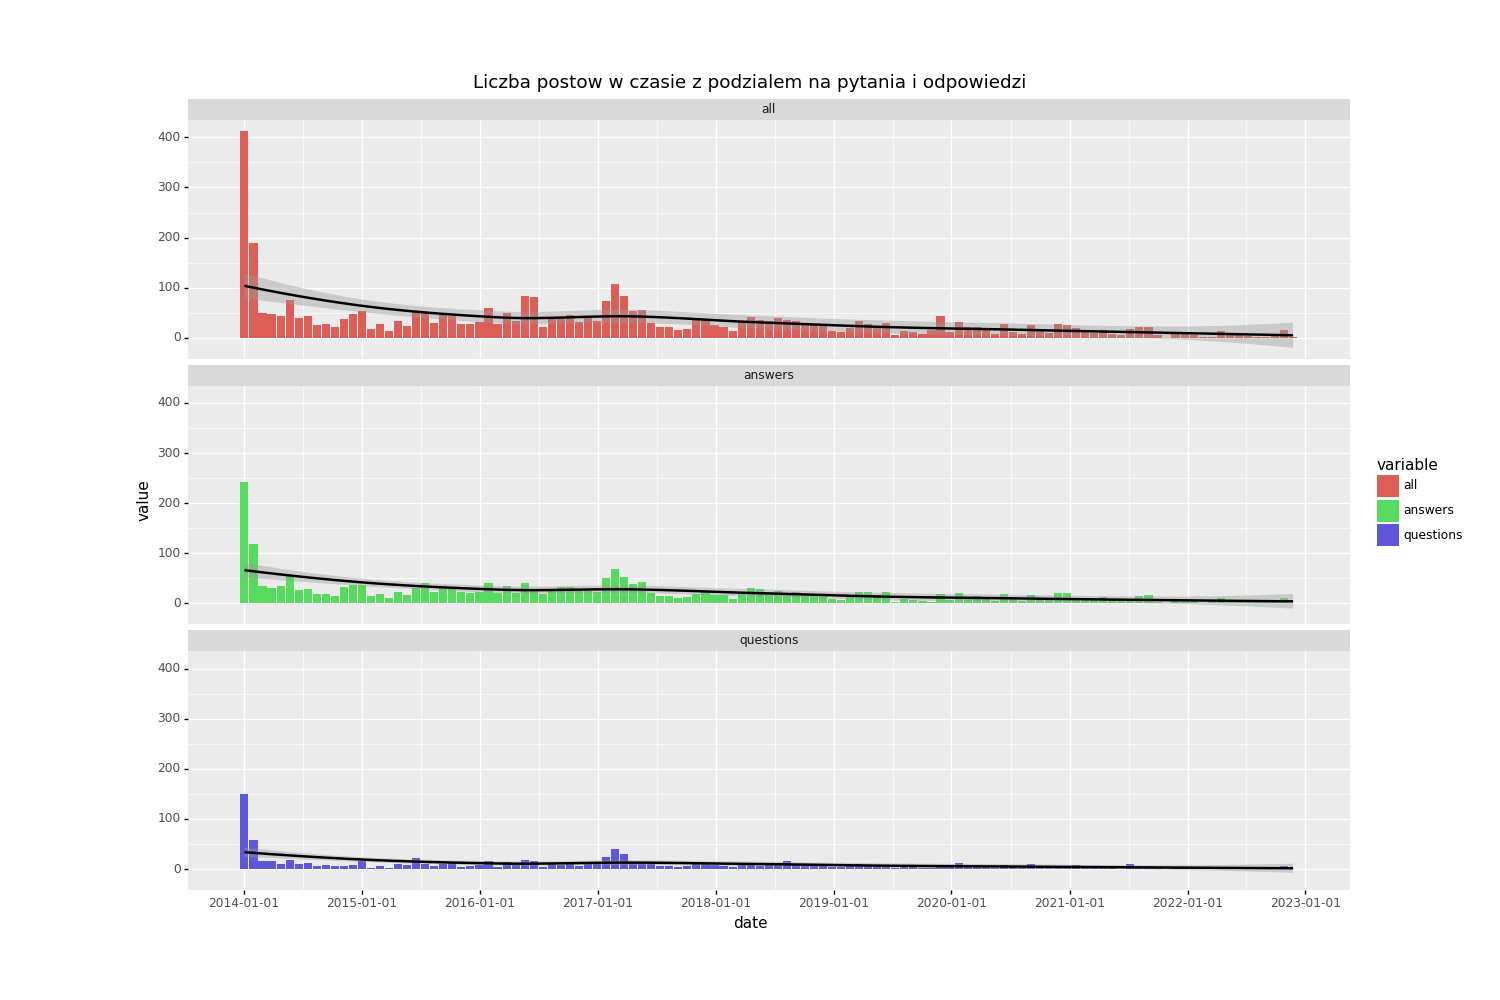

In [6]:
#| echo: false

from plotnine import aes, facet_wrap, ggplot, scale_x_datetime, options, stat_smooth, geom_col, ggtitle
from matplotlib import pyplot as plt
options.figure_size = (15, 10)

posts_long = posts_grouped.melt(id_vars=('date'), value_vars=('all', 'questions', 'answers'))
posts_long.head()

(ggplot(posts_long, aes(x='date', y='value', group='variable'))
    + geom_col(aes(fill='variable')) 
    + scale_x_datetime()
    + stat_smooth(method='loess') 
    + facet_wrap('variable', ncol=1)
    + ggtitle("Liczba postow w czasie z podzialem na pytania i odpowiedzi")
)

%matplot plt

## Retencja użytowników 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

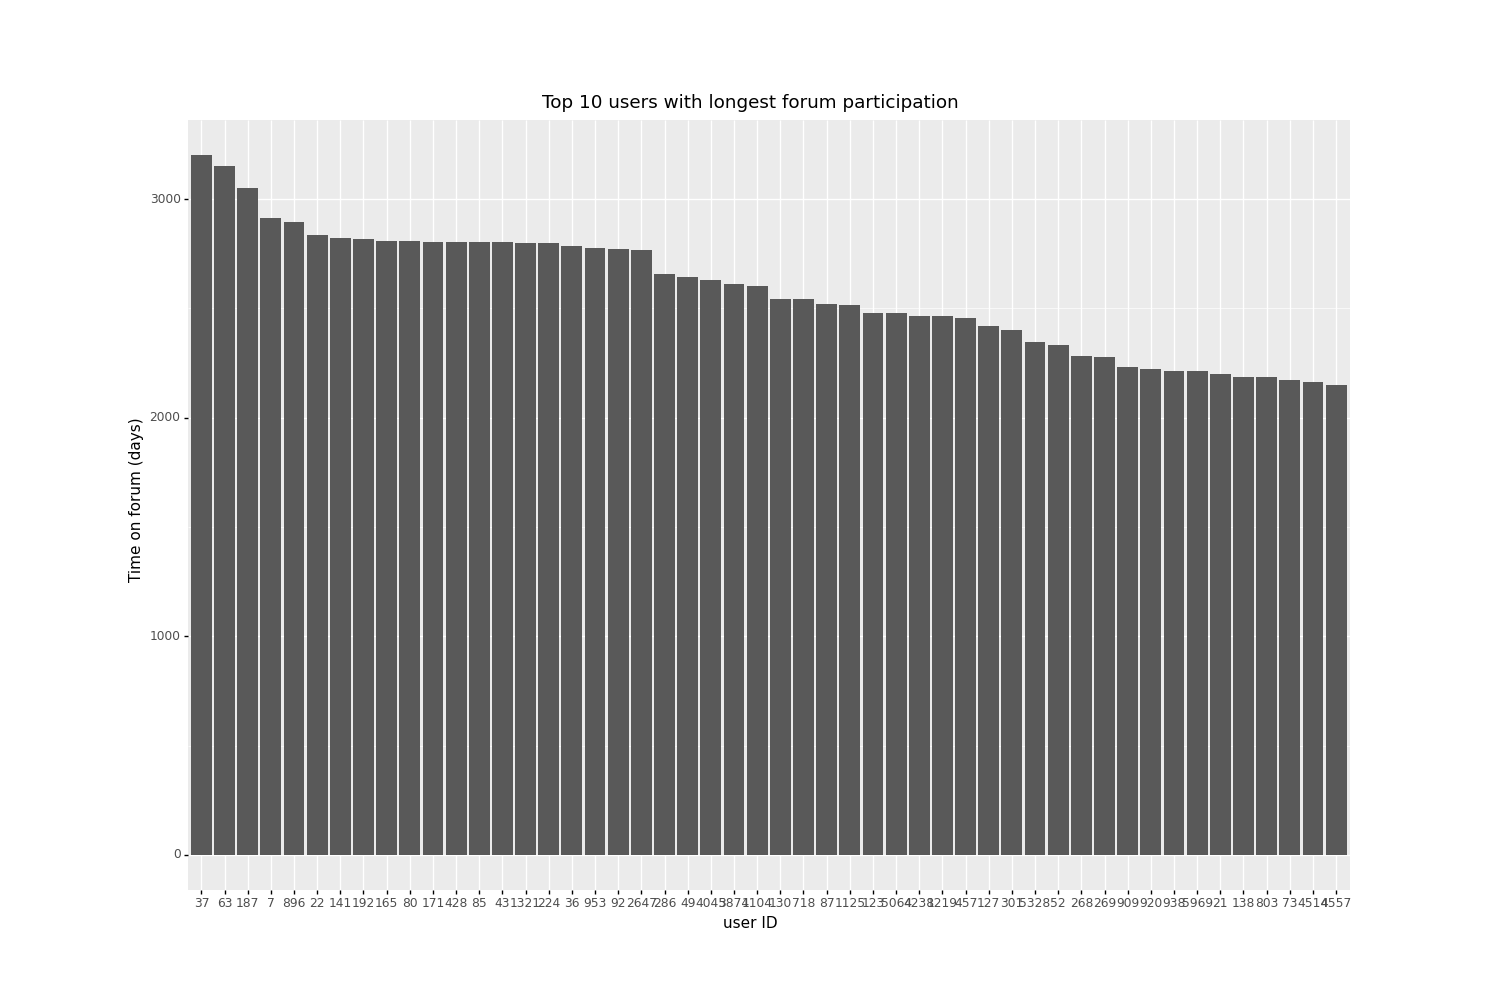

In [62]:
users = spark.read.format('parquet').load("s3://preprocessed-data-beer-and-wine/users")\
    .select(f.col('id'), f.col('creation_date'), f.col('display_name'))
users.cache()

posts_by_user = posts.select(
    f.col('owner_user_id'), 
    f.col('last_activity_date'), 
    f.col('id').alias('post_id')
    )
posts_and_users_joined = (users
    .filter(f.col('id') != -1) # remove bots
    .join(posts_by_user, users.id  == posts_by_user.owner_user_id, how="left" )
    .filter(f.col('post_id').isNotNull()) # remove users that never posted
    )

user_last_post = (posts_and_users_joined
    .groupBy(f.col('id'), f.col('creation_date'))
    .agg(
        f.max(f.col('last_activity_date'))
        )
    )

# time from account creation to last activity
user_last_post = user_last_post.withColumn(
    'diff',
    f.datediff(
        f.col('max(last_activity_date)'), 
        f.col('creation_date')
        ) 
    )

user_last_post_df = (user_last_post
    .orderBy(f.col('diff').desc())
    .limit(50)
    .withColumn('id_cat', f.col('id').cast('string'))
    .toPandas()
    )

import pandas as pd
# add sorted categories for pretty plotting
user_last_post_df['id_cat'] = pd.Categorical(user_last_post_df.id_cat, 
                                             categories=user_last_post_df.id_cat)

from plotnine import labs
(ggplot(user_last_post_df, aes(x='id_cat', y='diff'))
     + geom_col()
     + labs(x='user ID', 
            y='Time on forum (days)', 
            title='Top 10 users with longest forum participation')
)

%matplot plt

## Procent użytkowników którzy nigdy nic nie zapostowali

In [8]:
users_posts = (users.join(
    (posts.select(f.col('id').alias('post_id'), f.col('owner_user_id'))), on=[users.id == posts.owner_user_id], how="full")\
    .filter("id IS NOT NULL and NOT id = -1")
    )

users_posts.select([f.col('id'), f.col('post_id')])\
    .groupBy("id")\
        .agg(
            f.count(f.col('post_id')).alias('post_count')
        )\
    .agg(
        f.sum(f.when(f.col('post_count') == 0, f.lit(1)).otherwise(f.lit(0))).alias("not_posted"),
        f.count('id').alias('all')
    ) \
    .withColumn('% not posted', (f.col("not_posted") / f.col('all') * 100)).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----+-----------------+
|not_posted| all|     % not posted|
+----------+----+-----------------+
|      8044|9315|86.35534084809447|
+----------+----+-----------------+

## Statystyki 100 najwyżej oraz najniżej ocenianych pytań

In [9]:
#| echo: false

#1 - Question 2 - Answer 3 - Wiki 4 - TagWikiExcerpt 5 - TagWiki 6 - ModeratorNomination 7 -  WikiPlaceholder 8 - PrivilegeWiki
questions = (posts
    .select(f.col('id'), 
            f.col('body_clean'), 
            f.col('answer_count'), 
            f.col('view_count'), 
            f.col('tags'), 
            f.col('score'), 
            f.col('post_type_id')
           )
    .filter(f.col('post_type_id') == 1)
    .drop(f.col('post_type_id'))
    )

n_questions = 100

top_questions = (
    questions
        .orderBy(f.col('score'), ascending=False)
        .limit(n_questions)
        .withColumn('type', f.lit('top'))
    )
bottom_questions = (
    questions
        .orderBy(f.col('score'), ascending=True)
        .limit(n_questions)
        .withColumn('type', f.lit('bottom'))
    )

edge_questions = top_questions.unionAll(bottom_questions)

from pyspark.sql.functions import length
edge_questions = edge_questions.withColumn('post_len', f.length(f.col('body_clean')))
edge_questions_pd = edge_questions.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

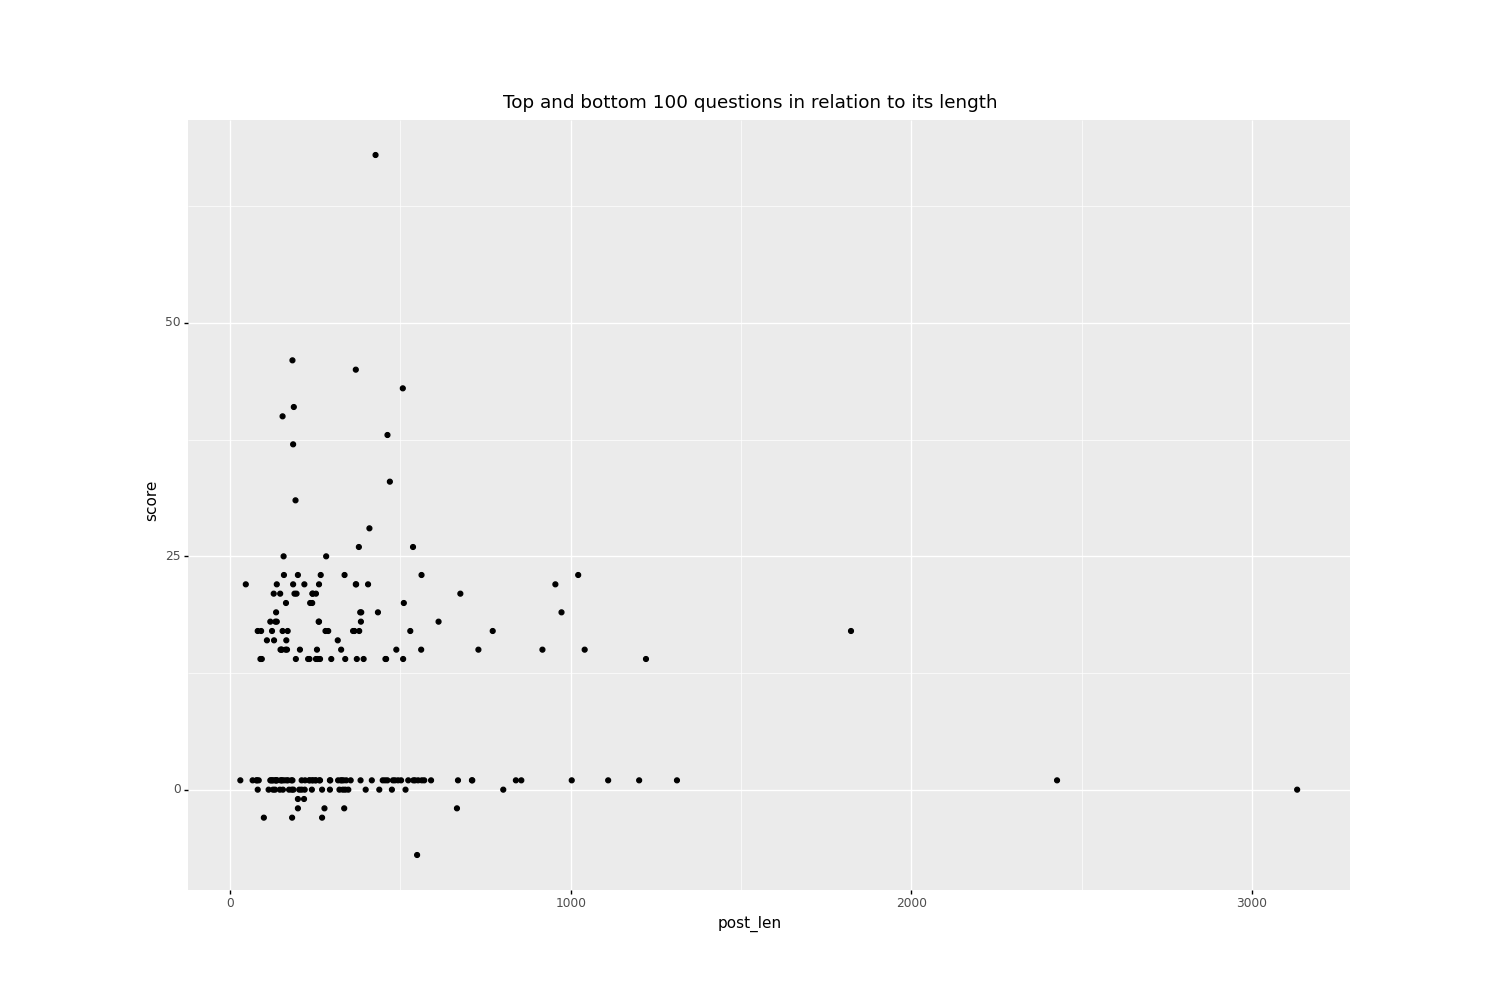

In [53]:
#| echo: false
from plotnine import ggplot, aes, geom_point, ggtitle

p1 = (ggplot(edge_questions_pd, aes(x = 'post_len', y = 'score') ) \
    + geom_point() \
    + ggtitle(f'Top and bottom {n_questions} questions in relation to its length')
)
p1
%matplot plt

In [11]:
edge_questions.groupby('type')\
    .agg(
        f.max(f.col('post_len')),
        f.min(f.col('post_len')),
        f.mean(f.col('post_len')).alias('mean'),
        f.stddev(f.col('post_len')).alias('std_dev'),
        f.percentile_approx(f.col('post_len'), 0.5).alias('median')
    ).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------------+-------------+------+------------------+------+
|  type|max(post_len)|min(post_len)|  mean|           std_dev|median|
+------+-------------+-------------+------+------------------+------+
|   top|         1823|           46|349.08|275.08858738430234|   261|
|bottom|         3133|           30|393.25| 426.8509397289348|   270|
+------+-------------+-------------+------+------------------+------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

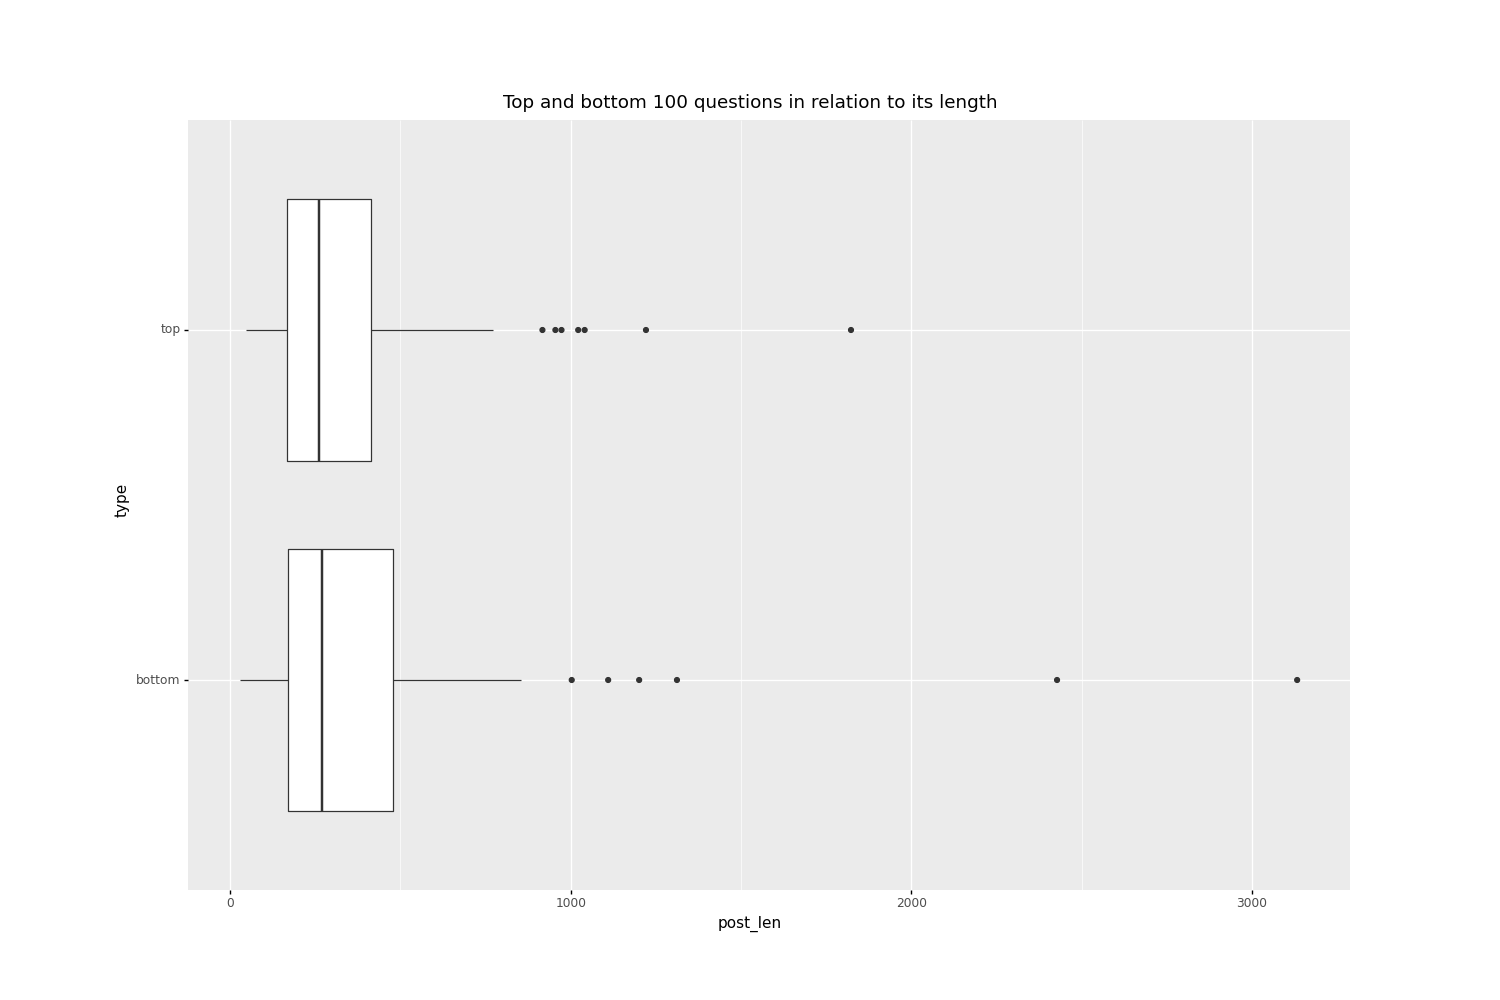

In [52]:
from plotnine import ggplot, aes, geom_boxplot, ggtitle, coord_flip

p2 = (ggplot(edge_questions_pd, aes(x = 'type', y = 'post_len') ) 
    + geom_boxplot() 
    + coord_flip()
    + ggtitle(f'Top and bottom {n_questions} questions in relation to its length'))
p2
%matplot plt

In [57]:
#| include: false

import patchworklib as pw
p1 = (ggplot(edge_questions_pd, aes(x = 'post_len', y = 'score') ) \
    + geom_point() \
    + ggtitle(f'Top and bottom {n_questions} questions in relation to its length')
)

p2 = (ggplot(edge_questions_pd, aes(x = 'type', y = 'post_len') ) 
    + geom_boxplot() 
    + coord_flip()
    + ggtitle(f'Top and bottom {n_questions} questions in relation to its length'))

g1 = pw.load_ggplot(p1)
g2 = pw.load_ggplot(p2)
g12 = (g1/g2)
g12

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

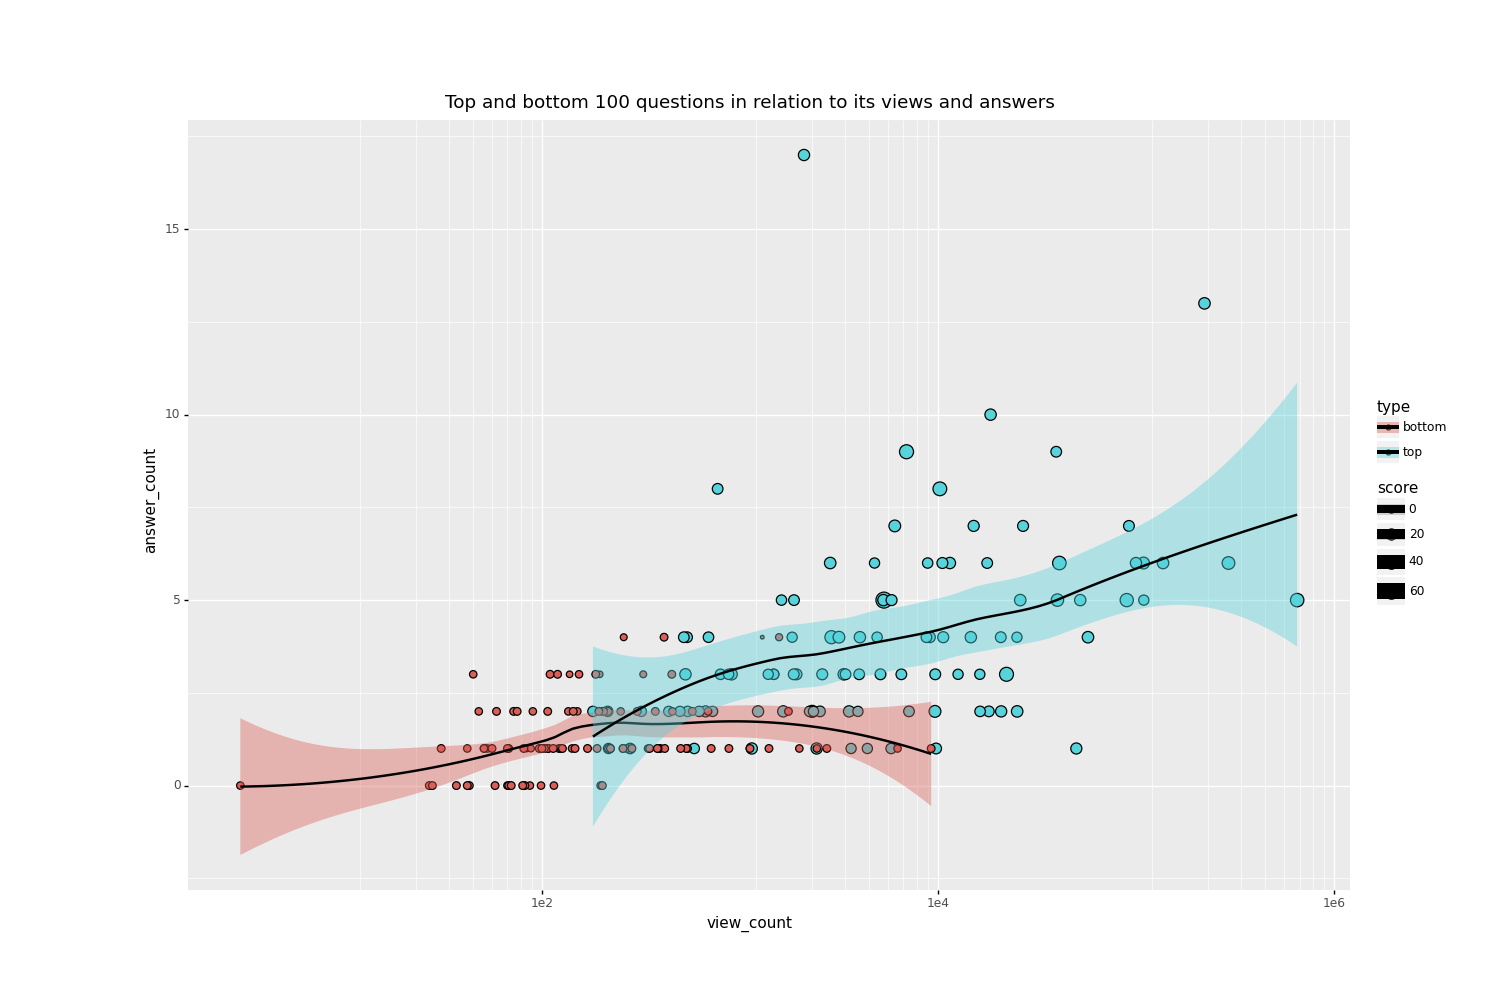

In [14]:
from plotnine import ggplot, aes, geom_point, ggtitle, scale_x_log10, geom_smooth

(ggplot(
    edge_questions_pd, 
    aes(
        x = 'view_count', 
        y = 'answer_count', 
        fill = 'type', 
        size = 'score') 
        ) 
    + geom_point() 
    + scale_x_log10()
    + geom_smooth()
    + ggtitle(f'Top and bottom {n_questions} questions in relation to its views and answers')
    )

%matplot plt

In [15]:
edge_questions.groupby('type')\
    .agg(
        f.max(f.col('answer_count')),
        f.min(f.col('answer_count')),
        f.mean(f.col('answer_count')).alias('mean'),
        f.stddev(f.col('answer_count')).alias('std_dev'),
        f.percentile_approx(f.col('answer_count'), 0.5).alias('median')
    ).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----------------+-----------------+----+------------------+------+
|  type|max(answer_count)|min(answer_count)|mean|           std_dev|median|
+------+-----------------+-----------------+----+------------------+------+
|   top|               17|                1|3.96| 2.581675910150324|     3|
|bottom|                4|                0|1.33|0.9954949025535493|     1|
+------+-----------------+-----------------+----+------------------+------+

In [16]:
edge_questions.groupby('type')\
    .agg(
        f.max(f.col('view_count')),
        f.min(f.col('view_count')),
        f.mean(f.col('view_count')).alias('mean'),
        f.stddev(f.col('view_count')).alias('std_dev'),
        f.percentile_approx(f.col('view_count'), 0.5).alias('median')
    ).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+---------------+---------------+--------+------------------+------+
|  type|max(view_count)|min(view_count)|    mean|           std_dev|median|
+------+---------------+---------------+--------+------------------+------+
|   top|         651993|            181|26289.01|  76654.3572582581|  4785|
|bottom|           9246|              3|  475.22|1172.8103395371531|   147|
+------+---------------+---------------+--------+------------------+------+

In [17]:
#| echo: false

#https://gist.github.com/dannymeijer/be3534470b205280e52dbbcbb19a9670


from pyspark.sql import DataFrame
from pyspark.sql import functions as f


def regexp_extract_all(
    df: DataFrame,
    regex: str,
    no_of_extracts: int,
    input_column_name: str,
    output_column_name: str = "output",
    empty_array_replace: bool = True,
):
    """Pyspark implementation for extracting all matches of a reg_exp_extract
    
    Background
    ----------
    The regular implementation of regexp_extract (as part of pyspark.sql.functions module)
    is not capable of returning more than 1 match on a regexp string at a time. This 
    function can be used to circumvent this limitation.
    
    How it works
    ------------
    You can specify a `no_of_extracts` which will essentially run the regexp_extract 
    function that number of times on the `input_column` of the `df` (`DataFrame`). 
    In between extracts, a set of interim columns are created where every 
    intermediate match is stored. A distinct array is created from these matches, 
    after which the interim columns are dropped. The resulting array is stored in 
    the defined `output_column`. Empty strings/values in the resulting array can 
    optionally be dropped or kept depending on how `empty_array_replace` is set 
    (default is True).
    
    Usage example
    -------------
    In the below example, we are extracting all email-addresses from a body of text.
    The returned DataFrame will have a new ArrayType column added named `email_addresses`
    
    > # Assuming `df` is a valid DataFrame containing a column named `text`
    > email_regex = r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"
    > df = regexp_extract_all(df, email_regex, 6, "text", "email_addresses", True)
    
    Parameters
    ----------
    df: DataFrame
        Input DataFrame
    
    regex: str
        Regexp string to extract from input DataFrame
    
    no_of_extracts: int
        Max number of occurrences to extract
    
    input_column_name: str
        Name of the input column
    
    output_column_name: str
        Name of the output column (default: output)
    
    empty_array_replace: bool
        If set to True, will replace empty arrays with null values (default: True)
    """
    repeats = range(0, no_of_extracts)

    # A set of interim columns are created that will be dropped afterwards
    match_columns = [f"___{r}___" for r in repeats]

    # Apply regexp_extract an r number of times
    for r in repeats:
        df = df.withColumn(
            match_columns[r],
            f.regexp_extract(
                f.col(input_column_name),
                # the input regex string is amended with ".*?"
                # and repeated an r number of times
                # r needs to be +1 as matching groups are 1-indexed
                "".join([f"{regex}.*?" for i in range(0, r + 1)]),
                r + 1,
            ),
        )

    # Create a distinct array with all empty strings removed
    df = df.withColumn(
        output_column_name,
        f.array_remove(f.array_distinct(f.array(match_columns)), ""),
    )

    # Replace empty string with None if empty_array_replace was set
    if empty_array_replace:
        df = df.withColumn(
            output_column_name,
            f.when(f.size(output_column_name) == 0, f.lit(None)).otherwise(
                f.col(output_column_name)
            ),
        )

    # Drop interim columns
    for c in match_columns:
        df = df.drop(c)

    return df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
#edge_questions.select(f.col('tags')).withColumn('tags_split', f.regexp_extract(f.col('tags'), r'<(\w+)>')).show()

edge_questions = regexp_extract_all(edge_questions, r'<(\w+)>', 99, "tags", "tags_split", True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
import pyspark.rdd as rdd
h = edge_questions.filter(f.col('type') == 'top').select(f.col('tags_split')).rdd
l = edge_questions.filter(f.col('type') == 'bottom').select(f.col('tags_split')).rdd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

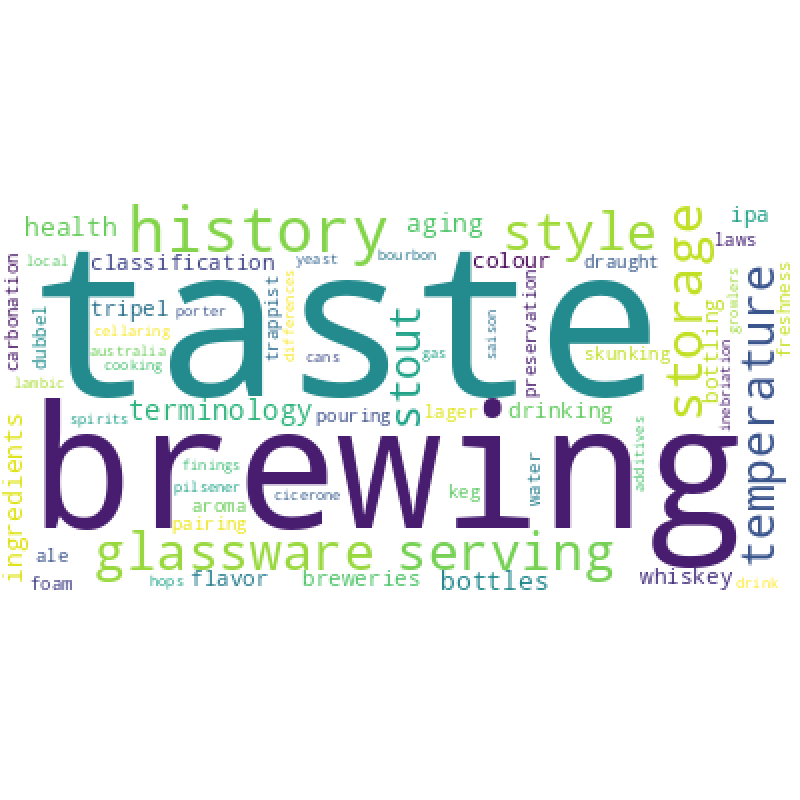

In [20]:
tags_rdd = h.flatMap(lambda x: [y if y is not None else "" for y in x])\
    .flatMap(lambda x: [x[y] for y in range(0, len(x))])

x = tags_rdd.collect()
tags_str = ''
for y in range(len(x)):
    tags_str += f"{x[y]} "

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(background_color ='white').generate(tags_str)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
%matplot plt

In [21]:
#| include: false

h.flatMap(lambda x: [y if y is not None else "" for y in x])\
    .flatMap(lambda x: [x[y] for y in range(0, len(x))])\
    .map(lambda x: (x, 1))\
    .aggregateByKey(0, (lambda acc,x: acc + x ), (lambda acc1,acc2: acc1+acc2))\
    .filter(lambda x: x[1] > 1)\
    .sortBy(lambda x: x[1], ascending=False)\
    .take(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('taste', 17), ('brewing', 14), ('history', 12), ('glassware', 8), ('storage', 8), ('serving', 8), ('style', 8), ('temperature', 6), ('stout', 5), ('terminology', 5)]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

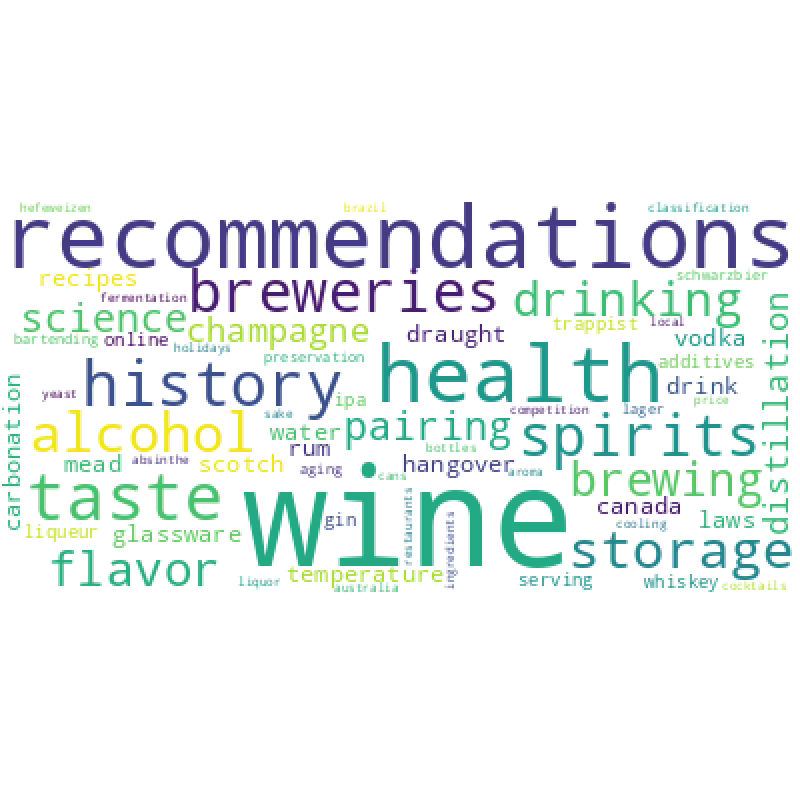

In [22]:
tags_rdd = l.flatMap(lambda x: [y if y is not None else "" for y in x])\
    .flatMap(lambda x: [x[y] for y in range(0, len(x))])

x = tags_rdd.collect()
tags_str = ''
for y in range(len(x)):
    tags_str += f"{x[y]} "

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(background_color ='white').generate(tags_str)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
%matplot plt

In [23]:
l.flatMap(lambda x: [y if y is not None else "" for y in x])\
    .flatMap(lambda x: [x[y] for y in range(0, len(x))])\
    .map(lambda x: (x, 1))\
    .aggregateByKey(0, (lambda acc,x: acc + x ), (lambda acc1,acc2: acc1+acc2))\
    .filter(lambda x: x[1] > 1)\
    .sortBy(lambda x: x[1], ascending=False)\
    .take(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('wine', 20), ('recommendations', 15), ('health', 12), ('taste', 8), ('history', 7), ('breweries', 6), ('spirits', 6), ('storage', 5), ('alcohol', 5), ('drinking', 4)]

## procent przypadków kiedy najwyżej oceniana odpowiedź to nie zaakceptowana odpowiedź

In [24]:
#1 - Question 2 - Answer 3 - Wiki 4 - TagWikiExcerpt 5 - TagWiki 6 - ModeratorNomination 7 -  WikiPlaceholder 8 - PrivilegeWiki
posts_tmp = (
    posts
    .select(
        f.col('id'), 
        f.col("parent_id"),
        f.col('accepted_answer_id'),
        f.col('answer_count'),
        f.col('score'),
        f.col('post_type_id')
    )
)

questions = posts_tmp.filter('post_type_id == 1 and answer_count > 0')\
    .select(
        f.col('id').alias('q_id'), 
        f.col('accepted_answer_id')
    )

answers = posts_tmp.filter(f.col('post_type_id') == 2)\
    .select(
        f.col('id').alias('a_id'), 
        f.col('parent_id'), 
        f.col('score')
    )

from pyspark.sql import Window

window_partition_agg = Window.partitionBy("q_id")

questions.join(answers, on=questions.q_id == answers.parent_id)\
    .sort(['q_id', 'a_id'])\
    .withColumn("max_score", f.max(f.col("score")).over(window_partition_agg))\
    .filter(f.col("score") == f.col("max_score"))\
    .filter(f.col("accepted_answer_id").isNotNull())\
    .withColumn("is_accepted_best", f.col("accepted_answer_id") == f.col("a_id"))\
    .agg(
        f.sum(f.col("is_accepted_best").cast("integer")).alias("sum"),
        f.count(f.col("q_id")).alias("count")
    )\
    .withColumn("percent", (f.col("count") - f.col("sum")) / f.col("count") * 100).show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----+------------------+
|sum|count|           percent|
+---+-----+------------------+
|646|  740|12.702702702702704|
+---+-----+------------------+

## Porównanie statystyk ocen odpowiedzi zaakceptowanych do pozostałych odpowiedzi

Pośród odpowiedzi na zadawane pytania wyróżniono 3 kategorie: 

    1. odpowiedź zaakceptowana (`is_accepted=true`)
    2. odpowiedź niezaakceptowana (`is_accepted=false`)
    3. odpowiedź niezaakceptowana ale równocześnie brak jest zaakceptowanej odpowiedzi na to pytanie (`is_accepted=null`)

In [25]:
window_partition_agg = Window.partitionBy("q_id")

questions.join(answers, on=questions.q_id == answers.parent_id)\
    .sort(['q_id', 'a_id'])\
    .withColumn("is_accepted", f.col("accepted_answer_id") == f.col("a_id"))\
    .groupBy(f.col("is_accepted")).agg(
        f.avg(f.col("score")).alias("avg_score"),
        f.stddev(f.col("score")).alias("std_score"),
        f.min(f.col("score")).alias("min_score"),
        f.max(f.col("score")).alias("max_score"),
        f.count("a_id")
    ).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+-----------------+---------+---------+-----------+
|is_accepted|         avg_score|        std_score|min_score|max_score|count(a_id)|
+-----------+------------------+-----------------+---------+---------+-----------+
|       null|2.7518716577540108|3.170466333446737|       -5|       30|        935|
|       true| 6.407246376811594|5.907924835408443|        0|       46|        690|
|      false|2.5741150442477876| 2.74154984661979|       -4|       26|        904|
+-----------+------------------+-----------------+---------+---------+-----------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

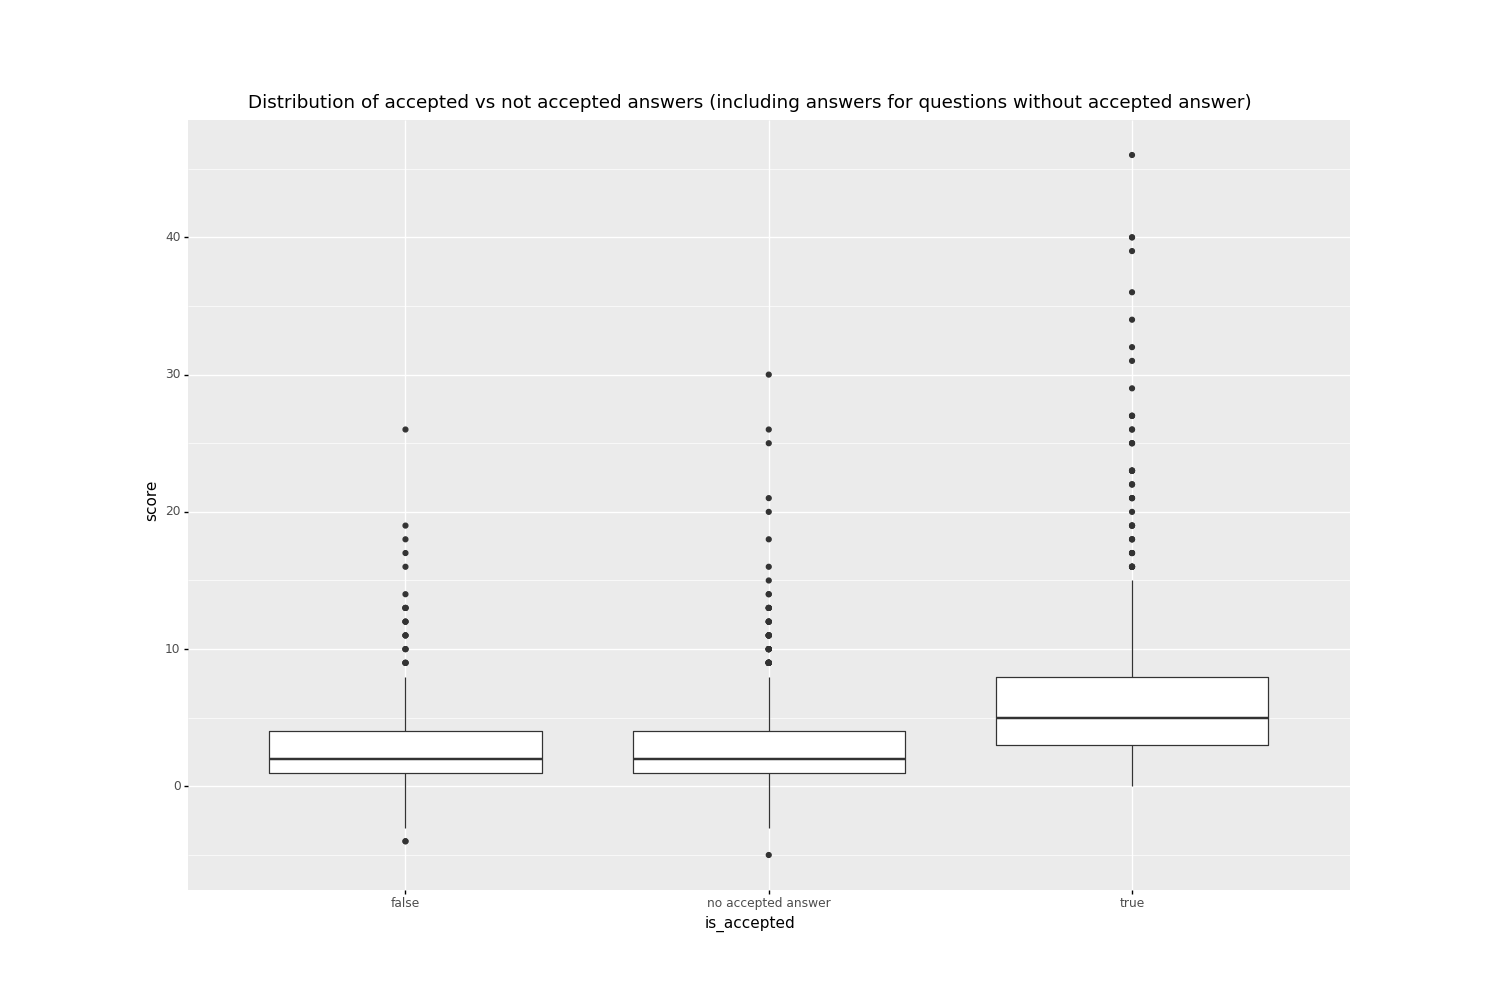

In [26]:
accepted_df = questions.join(answers, on=questions.q_id == answers.parent_id)\
    .sort(['q_id', 'a_id'])\
    .withColumn("is_accepted", (f.col("accepted_answer_id") == f.col("a_id")).cast("string"))\
    .withColumn("is_accepted", f.when(f.col("is_accepted").isNull(), "no accepted answer").otherwise(f.col("is_accepted"))).toPandas()

(ggplot(accepted_df, aes(x="is_accepted", y="score"))\
    +geom_boxplot()\
    +ggtitle("Distribution of accepted vs not accepted answers (including answers for questions without accepted answer)"))
%matplot plt

## średni czas od pojawienia się pytania do pojawienia się zaakceptowanej odpowiedzi

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

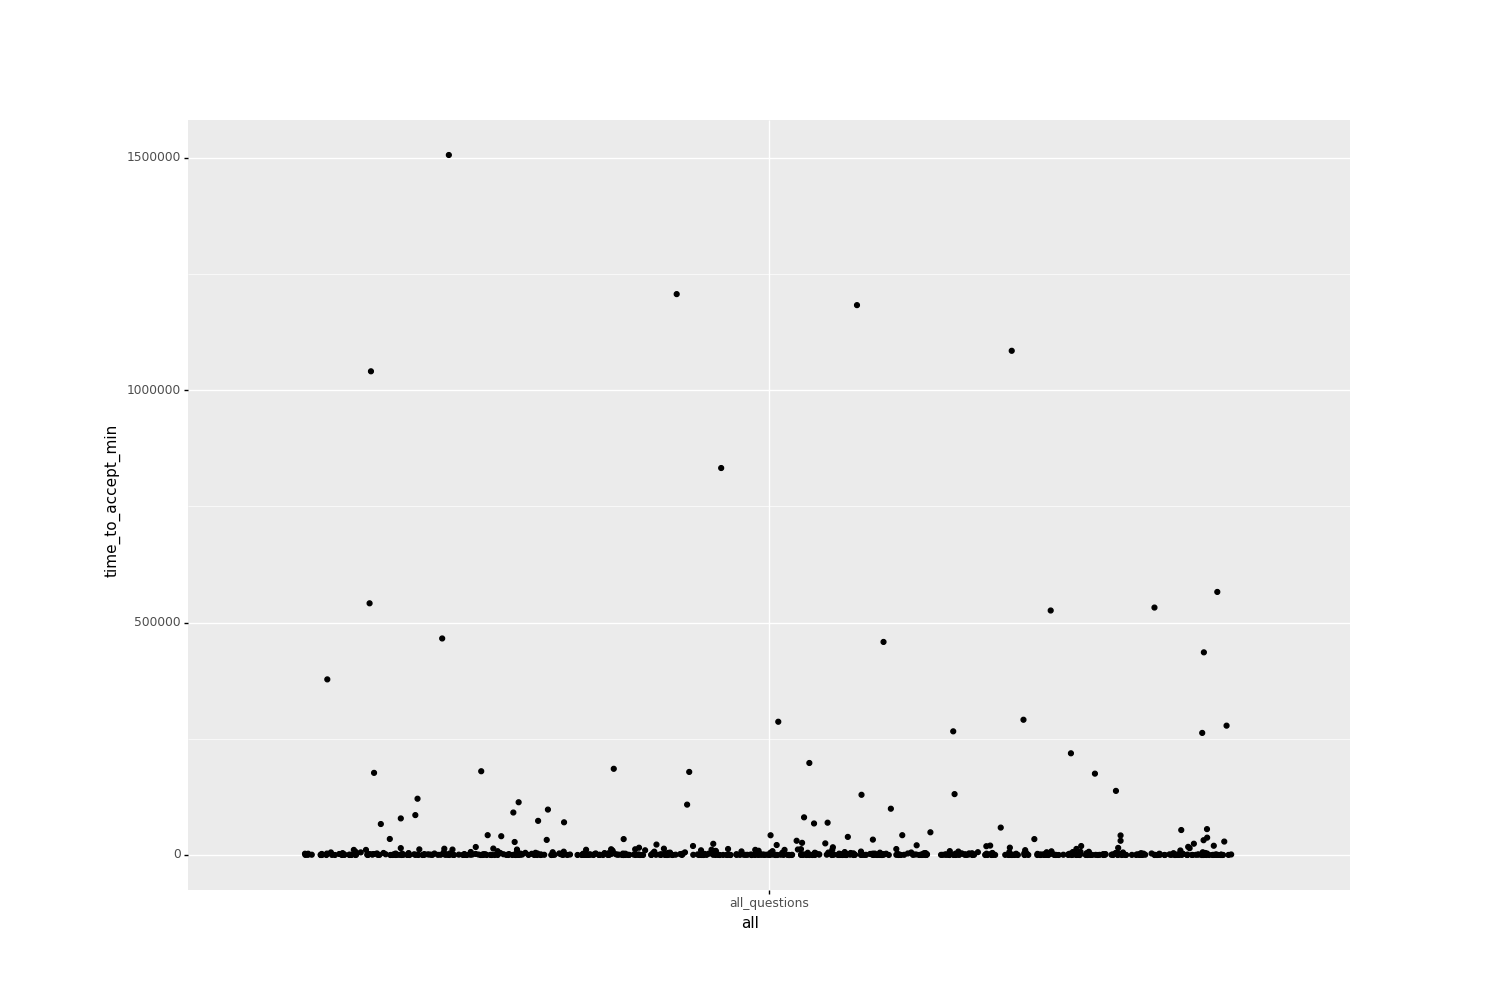

In [27]:
# keep only questions with answers
questions = posts.filter(f.col('post_type_id') == 1).filter(f.col('answer_count') > 0).select([f.col('id').alias('q_id'), f.col('creation_date').alias('q_creation_date'), f.col('accepted_answer_id')])
answers  = posts.filter(f.col('post_type_id') == 2).select([f.col('id').alias('a_id'), f.col('parent_id').alias('a_parent_id'), f.col('creation_date').alias('a_creation_date')])
#posts.show(1, vertical=True)
time_to_accept = questions.join(answers, on=[questions.accepted_answer_id==answers.a_id])\
    .withColumn('time_to_accept_sec', f.unix_timestamp('a_creation_date') - f.unix_timestamp('q_creation_date'))\
    .withColumn('time_to_accept_min', f.round(f.col('time_to_accept_sec') / 60, 2))

time_to_accept.agg(
        f.avg('time_to_accept_min'),
        f.stddev('time_to_accept_min'),
        f.percentile_approx("time_to_accept_min", [0.25, 0.5, 0.75], 1000000).alias("quantiles")
    ).show(truncate=False)


time_to_accept_pd = time_to_accept.withColumn('all', f.lit("all_questions")).toPandas()

from plotnine import geom_jitter
(ggplot(time_to_accept_pd, aes(x='all', y="time_to_accept_min"))\
    +geom_jitter())
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

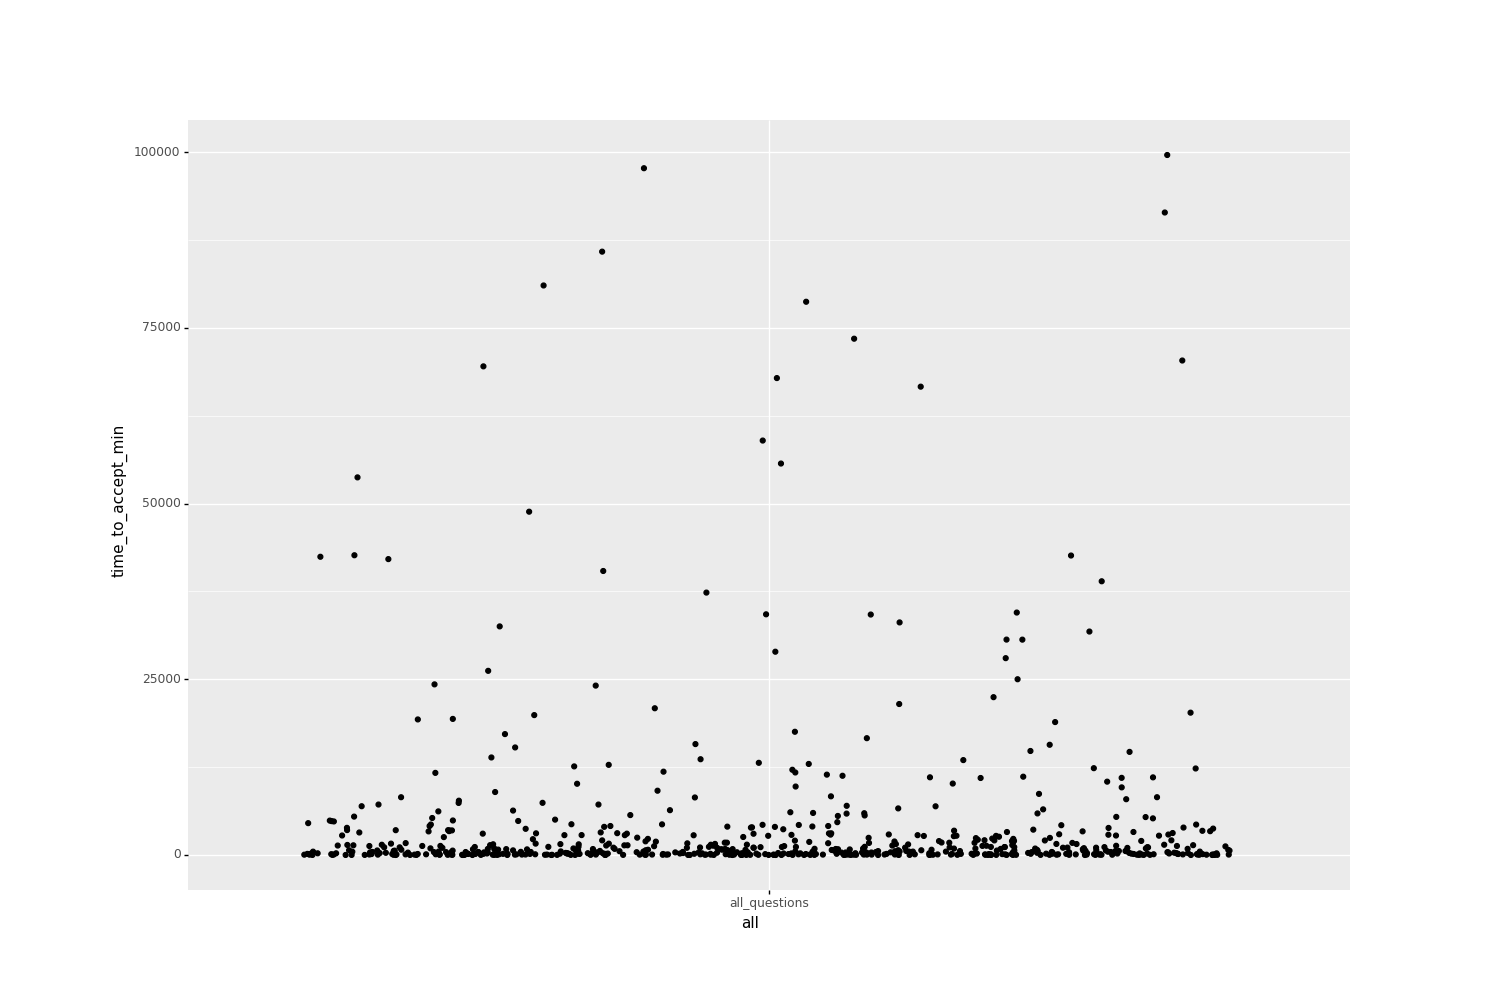

In [28]:
no_outliers = time_to_accept.filter(f.col('time_to_accept_min') < 100000)

no_outliers.agg(
        f.avg('time_to_accept_min'),
        f.stddev('time_to_accept_min'),
        f.percentile_approx("time_to_accept_min", [0.25, 0.5, 0.75], 1000000).alias("quantiles")
    ).show(truncate=False)

no_outliers_pd = no_outliers.withColumn('all', f.lit("all_questions")).toPandas()
(ggplot(no_outliers_pd, aes(x='all', y="time_to_accept_min"))\
    +geom_jitter())
%matplot plt

## top N tagów które wygenerowały najwięcej wyświetleń

In [29]:
tags_views = posts.select(['tags', 'view_count'])
tags_views_agg = regexp_extract_all(tags_views, r'<(\w+)>', 99, "tags", "tags_split", True)\
    .select([f.explode(f.col('tags_split')).alias("tag"), f.col("view_count")])\
    .filter(f.col("view_count").isNotNull())\
    .groupBy('tag')\
    .agg(
        f.sum("view_count").alias("sum_views")
    )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
#| include: false
tag_top_views = tags_views_agg.orderBy("sum_views", ascending=False).limit(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
tag_top_views.show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------+
|            tag|sum_views|
+---------------+---------+
|          taste|  1349051|
|         health|  1316064|
|   preservation|   686106|
|        storage|   558949|
|        whiskey|   470841|
|        bourbon|   332036|
|        brewing|   311902|
|            ipa|   297350|
|        spirits|   262159|
|       drinking|   232794|
|    temperature|   222620|
|          drink|   213363|
|        tequila|   205116|
|        alcohol|   196760|
|recommendations|   189954|
|           wine|   189042|
|        history|   173237|
|         flavor|   171669|
|          style|   171299|
|        pairing|   168609|
+---------------+---------+

## liczba postów w czasie dla każdego z top N tagów (lineplot/barplot)

In [32]:
#1 - Question 2 - Answer 3 - Wiki 4 - TagWikiExcerpt 5 - TagWiki 6 - ModeratorNomination 7 -  WikiPlaceholder 8 - PrivilegeWiki
posts_tmp = posts.select(f.col('id'), f.col('creation_date'), f.col('tags'))

posts_tags_time = regexp_extract_all(posts_tmp, r'<(\w+)>', 99, "tags", "tags_split", True)\
    .withColumn('tag', f.explode(f.col('tags_split')))\
    .filter(f.col("tag").isNotNull())

top_posts_tags_time = (
    posts_tags_time
        .join(
            tag_top_views,
            on="tag",
            how="inner")
        .select(
            f.col('id'),
            f.col('tag'), 
            f.col('creation_date')
        ).distinct()
    )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

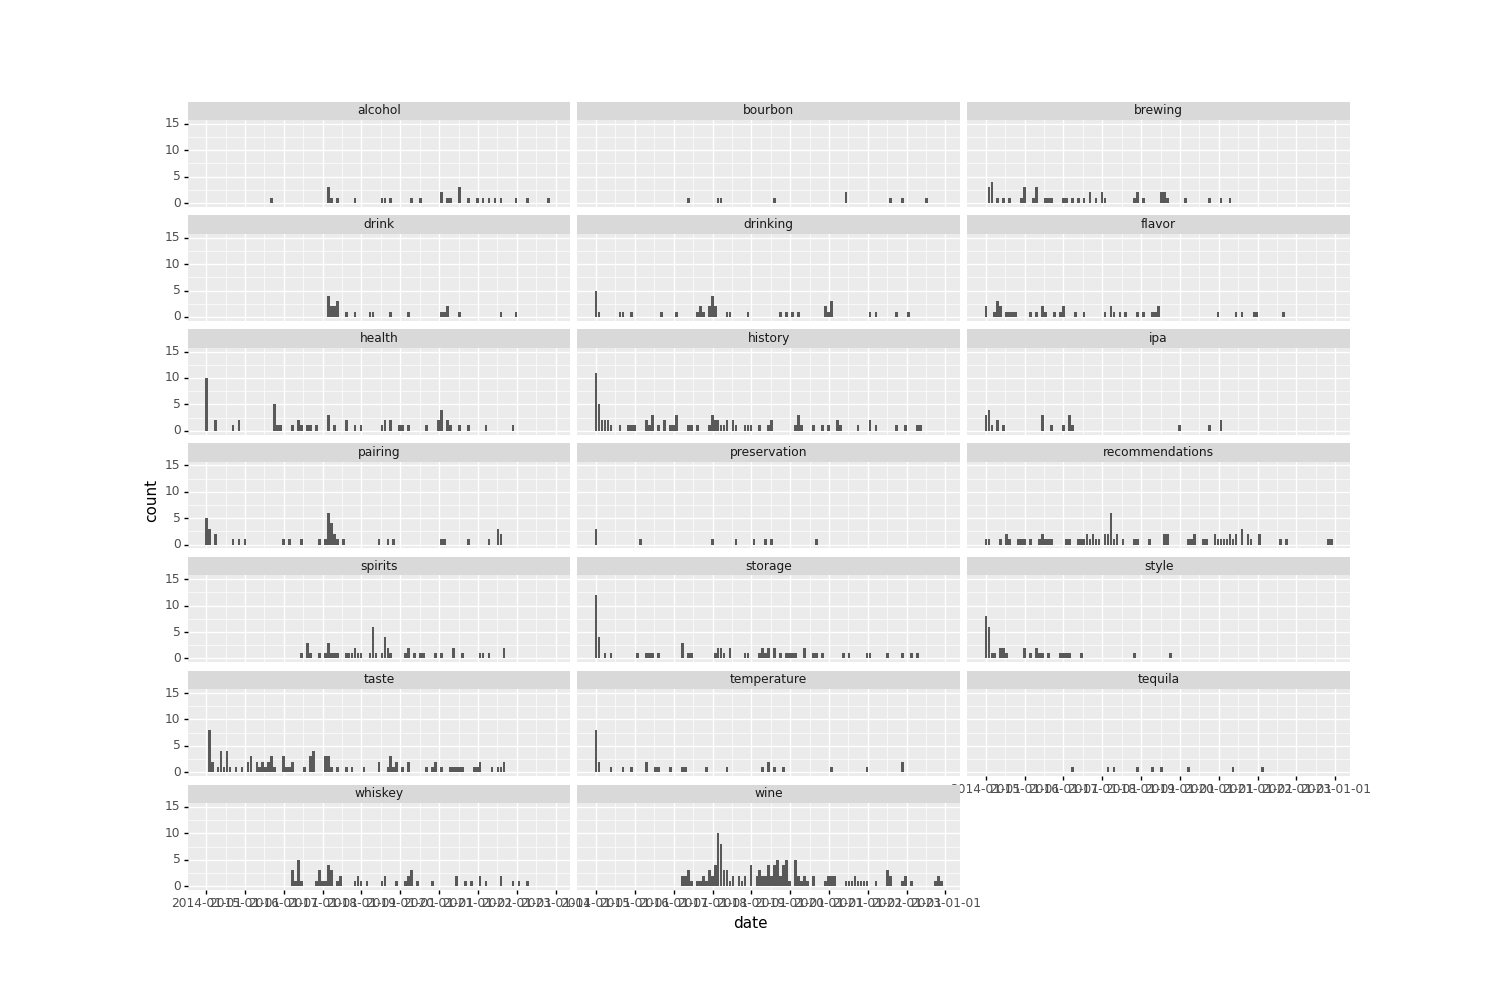

In [33]:
#| include: false

from plotnine import geom_bar, ylim
top_posts_tags_time_agg = top_posts_tags_time.groupBy(
        f.window('creation_date', '4 weeks'), f.col("tag")
    ) \
    .agg(
        f.sum(f.lit(1)).alias('count')
    )\
    .withColumn('date', f.col('window.start').cast('date'))

top_posts_tags_time_agg_pd = top_posts_tags_time_agg.toPandas()

(ggplot(top_posts_tags_time_agg_pd, aes("date", "count"))\
    + scale_x_datetime()\
    + geom_col() \
    + facet_wrap("tag", ncol=3) \
    + ylim(0, 15))

%matplot plt

## najczęściej pojawiające się słowa w tytułach (z pominięciem stopwords)

In [34]:
from bs4 import BeautifulSoup
from html import unescape
from pyspark.sql.functions import udf, regexp_replace
from pyspark.sql.types import *
# remove html tags
def tags_remove(s):
    soup = BeautifulSoup(unescape(s), 'lxml')
    return soup.text

udf_tags_remove = udf(lambda m: tags_remove(m))

titles = posts.filter(f.col("title").isNotNull()).select(f.col("title"))\
    .withColumn("title_clean", f.lower(f.col("title")))\
    .withColumn("title_clean", regexp_replace('title_clean', "[^a-zA-Z\\s]", " "))

from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
udf_filter_length = udf(lambda row: [x for x in row if len(x) > 1], ArrayType(StringType()))

stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda token: stemmer.stem(token), StringType())

tokenizer = Tokenizer(inputCol='title_clean', outputCol='words_token')
title_tokens = tokenizer.transform(titles).withColumn('words_token', udf_filter_length(f.col('words_token')))

remover = StopWordsRemover(inputCol='words_token', outputCol='words_no_stop')
title_tokens_no_stop = remover.transform(title_tokens)
exploded = title_tokens_no_stop.withColumn("words", f.explode(f.col("words_no_stop")))

title_stem = exploded.withColumn('words_stem', stemmer_udf("words"))

word_lookup = title_stem.select([f.col("words"), f.col("words_stem")]).distinct()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
word_lookup.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+
|     words|words_stem|
+----------+----------+
|  learning|     learn|
| regionali| regionali|
|   bavaria|   bavaria|
|     likes|      like|
|  devenish|  devenish|
|caipirinha|caipirinha|
|     units|      unit|
|      pale|      pale|
|     italy|     itali|
|       ask|       ask|
+----------+----------+
only showing top 10 rows

In [36]:
(title_stem
     .groupBy("words_stem")
     .agg(f.count("title").alias('count'))
     .orderBy('count', ascending=False)
     .show(10)
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|words_stem|count|
+----------+-----+
|      beer|  476|
|      wine|  152|
|     drink|  105|
|   alcohol|   88|
|    differ|   73|
|     bottl|   69|
|       use|   51|
|      tast|   47|
|      brew|   43|
|      make|   41|
+----------+-----+
only showing top 10 rows